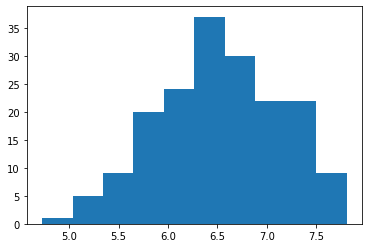

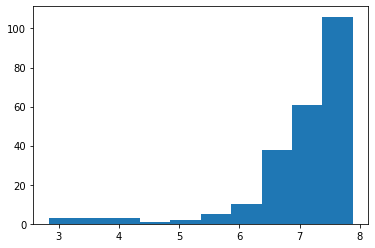

0.539009160834495
0.545088861702724


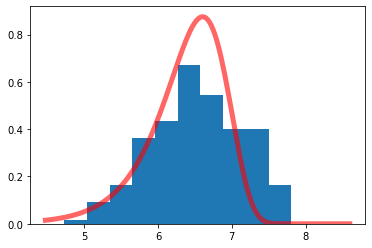

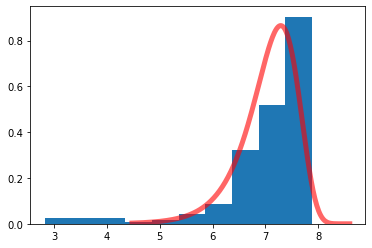

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 20 16:25:24 2021

@author: alise
"""

import functions as func
import xgboost as xgb
import config as cfg
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sksurv.svm import FastKernelSurvivalSVM
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sksurv.metrics import concordance_index_censored, integrated_brier_score, brier_score
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.utils import concordance_index
from scipy.stats import gumbel_r, norm, logistic
import lifelines.datasets as dset
import math
from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec
import warnings
from scipy.special import erf
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

step = cfg.step

def objective_my(predt, dtrain):
    '''Objective.
    '''
    delta_loc = dtrain.get_float_info('label_lower_bound')
    grad = func.gradient(predt, dtrain,std_S,std_C,delta_loc,theta)
    hess = func.hessian(predt, dtrain,std_S,std_C,delta_loc,theta)
    return grad, hess


def objective_ind(predt, dtrain):
    '''Objective.
    '''
    delta = dtrain.get_float_info('label_lower_bound')
    grad = func.gradient_ind(predt, dtrain,std_S,std_C,delta,theta)
    hess = func.hessian_ind(predt, dtrain,std_S,std_C,delta,theta)
    return grad, hess

def score_survival_model_my(predt: np.ndarray, dtrain: xgb.DMatrix):
    result = concordance_index(dtrain.get_label(),np.exp(predt),dtrain.get_float_info('label_lower_bound').astype(bool))
    return 'C-index',result

def score_survival_model_aft(predt: np.ndarray, dtrain: xgb.DMatrix):
    y_upper_bound = np.where(dtrain.get_float_info('label_upper_bound')==np.inf, 0, 1)
    result = concordance_index(dtrain.get_float_info('label_lower_bound'),predt,y_upper_bound.astype(bool))
    return 'C-index',result

def score_brier(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    delt = dtrain.get_float_info('label_lower_bound')
    y_str_t =  np.vstack((delt, y)).T
    y_str_t = np.core.records.fromarrays(y_str_t.transpose(),
                                                 names='delta, y, col3',
                                                 formats = 'bool, f8')
    
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = np.exp(-(i/(np.exp(predt)))**(1/std_S))
        if j == 0:
            survprob = np.exp(-(i/(y_exp_test))**(1/std_S))
            j += 1
        else:
            survprob = np.c_[survprob,s_t]
    result = integrated_brier_score(y_str, y_str_t, survprob, np.arange(t_t.min(),t_t.max()))
    return 'Brier',result

results = pd.DataFrame()
results_c = pd.DataFrame()

if cfg.evals == 'c':
    eval_method = score_survival_model_my
    eval_method_aft = score_survival_model_aft
    state = True
elif cfg.evals == 'mae':
    eval_method = func.scorer
    eval_method_aft = func.scorer_aft
    state = False
    

#-------------- Import Data ------------------


raw_dataset = dset.load_gbsg2()
# # Creating the time and event columns
time_column = 'time'
event_column = 'cens'
  
 
# Creating one-hot vectors
category_columns = ['horTh', 'menostat','tgrade']
dataset = pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()
 
# Number of samples in the dataset
N = dataset.shape[0]
 
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.4, random_state = cfg.kSeed+1, stratify = dataset[event_column])
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
 
# Creating the X, T and E inputs
X, X_t = data_train[features], data_test[features]
t, t_t = data_train[time_column], data_test[time_column]
e, e_t = data_train[event_column], data_test[event_column]
 

t_S = []
t_U = []
i = 0
 
for value in e:
    if value == 1:
        t_S.append(t[i])
    elif value==0:
        t_U.append(t[i])
    i += 1
     
t_S= np.array(t_S).astype(float)
t_U = np.array(t_U).astype(float)
 
t_S_log = np.log(t_S)
t_U_log = np.log(t_U)
 
sigma_S = np.std(t_S_log)
sigma_U = np.std(t_U_log)

plt.hist(t_S_log)
plt.show()
plt.hist(t_U_log)
plt.show()

def fit_dist_norm(dist,loc_add = 0,scale_add=0):
    fig, ax = plt.subplots(1, 1)
    loc, scale = norm.fit(dist)
    x = np.linspace(norm.ppf(0.01)+2,
                norm.ppf(0.99)+2, len(dist))
    t_S_fit = ((1)/((scale+scale_add)*math.sqrt(2*math.pi)))*np.exp(-0.5*((x-loc)/(scale+scale_add))**2)
    ax.plot(x, t_S_fit,
           'r-', lw=5, alpha=0.6, label='pdf')
    ax.hist(dist, density = True)
    return(loc,scale)

def fit_dist_gumbel(dist,loc_add = 0,scale_add=0):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(gumbel_r.ppf(0.01)+6,
                    gumbel_r.ppf(0.99)+4, len(dist))
    loc, scale = gumbel_r.fit(dist)
    t_S_fit = (1/(scale+scale_add))*np.exp((x-loc+ loc_add)/(scale+scale_add))*np.exp(-np.exp((x-loc+ loc_add)/(scale+scale_add)))
    ax.plot(x, t_S_fit,
           'r-', lw=5, alpha=0.6, label='pdf')
    ax.hist(dist, density = True)
    return(loc,scale)

def fit_dist_logistic(dist,loc_add = 0,scale_add=0):
    fig, ax = plt.subplots(1, 1)
    loc, scale = logistic.fit(dist)
    x = np.linspace(logistic.ppf(0.01)+3,
                logistic.ppf(0.99), len(dist))
    t_S_fit = (np.exp(-(x-(loc+loc_add))/(scale+scale_add)))/((scale+scale_add)*(1+np.exp(-(x-(loc+loc_add))/(scale+scale_add)))**2)
    ax.plot(x, t_S_fit,
           'r-', lw=5, alpha=0.6, label='pdf')
    ax.hist(dist, density = True)
    return(loc,scale)


loc_add_S = cfg.loc_add_S
scale_add_S = cfg.scale_add_S
loc_S, scale_S = fit_dist_gumbel(t_S_log,loc_add_S,scale_add_S)
loc_S = loc_S+loc_add_S
scale_S = scale_S+scale_add_S
std_S = scale_S*math.pi/math.sqrt(6)

loc_add_U = cfg.loc_add_U
scale_add_U = cfg.scale_add_U
loc_U, scale_U = fit_dist_gumbel(t_U_log,loc_add_U,scale_add_U)
loc_U = loc_U+loc_add_U
scale_U = scale_U+scale_add_U
std_C = scale_U*math.pi/math.sqrt(6)



dtrain = xgb.DMatrix(X, label = t)
dtrain.set_float_info('label_lower_bound', e)

dtest = xgb.DMatrix(X_t, label = t_t)
dtest.set_float_info('label_lower_bound', e_t)

X1_reshape = X
X1_reshape_t = X_t
delta = e
delta_t = e_t
y = t
y_t = t_t

print(std_S)
print(std_C)

In [ ]:
# ------------------ CV -----------------------------

theta_list = [1.2,1.3,1.5,1.7,1.8]
#theta_list = [0.5,1.3,1.5,1.8,2.0]
#theta_list= [0.0]
i = 0

skf = StratifiedKFold(n_splits=2, random_state = cfg.kSeed, shuffle=True)
xgb_cv_result = np.empty((5,3))

for thet in theta_list:
    theta = thet
    print(theta)
    
    params = {'eta': cfg.eta,
          'tree_method':'hist',
          'seed': cfg.kSeed,
          'disable_default_eval_metric': 1,
          'max_depth' : cfg.max_depth,
         'min_child_weight': 0}
    
    xgb_my = xgb.cv(params,dtrain,num_boost_round=15000,nfold = 2, obj = objective_my, feval=eval_method,maximize = state,early_stopping_rounds=3000
                    ,shuffle = True,seed = cfg.kSeed
             #       ,stratified = True, seed = cfg.kSeed                   
                    )
    
    kBoostRound_my = len(xgb_my)
    
    xgb_cv_result[i][0] = xgb_my.iloc[-1,2]
    xgb_cv_result[i][1] = kBoostRound_my
    xgb_cv_result[i][2] = theta
    i +=1

theta = xgb_cv_result.T[2][np.where(xgb_cv_result.T[0]==np.amax(xgb_cv_result.T[0]))][0]
kBoostRound_my = int(xgb_cv_result.T[1][np.where(xgb_cv_result.T[0]==np.amax(xgb_cv_result.T[0]))][0])

print('Best theta: ' + str(theta))

# ------------------ Boosting AFT with informative censoring 



bst = xgb.train({'tree_method': 'hist', 'seed': cfg.kSeed,
           'disable_default_eval_metric': 1, 'eta' : cfg.eta, 'max_depth' : cfg.max_depth, 'min_child_weight': 0,
 #          'min_split_loss':0, 'max_delta_step':0, 'lambda':0, 'alpha':0
           },
          dtrain=dtrain,
          num_boost_round=kBoostRound_my,
          obj=objective_my,
          feval=eval_method,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')])


bst.dump_model('dump.raw.txt')

y_exp_test = np.exp(bst.predict(dtest))

# ------------------ Boosting AFT with independency

dtrain_aft= xgb.DMatrix(X)
y_lower_bound = t
y_upper_bound = np.where(e>0, t, +np.inf)
dtrain_aft.set_float_info('label_lower_bound', y_lower_bound)
dtrain_aft.set_float_info('label_upper_bound', y_upper_bound)
dtest_aft= xgb.DMatrix(X_t)
y_lower_bound_t = t_t
y_upper_bound_t =  np.where(e_t>0, t_t, +np.inf)
dtest_aft.set_float_info('label_lower_bound', y_lower_bound_t)
dtest_aft.set_float_info('label_upper_bound', y_upper_bound_t)

if cfg.dist_s == 'weibull':
    params_aft = {'objective': 'survival:aft',
              'eval_metric': 'aft-nloglik',
              'aft_loss_distribution': 'extreme',
              'aft_loss_distribution_scale': std_S,
              'tree_method': 'hist', 'learning_rate': cfg.eta2, 'max_depth': cfg.max_depth,
              'disable_default_eval_metric': 1,
              'min_child_weight': 0}
elif cfg.dist_s == 'loglogistic':
    params_aft = {'objective': 'survival:aft',
              'eval_metric': 'aft-nloglik',
              'aft_loss_distribution': 'logistic',
              'aft_loss_distribution_scale': std_S,
              'tree_method': 'hist', 'learning_rate': cfg.eta2, 'max_depth': cfg.max_depth,
              'disable_default_eval_metric': 1,
              'min_child_weight': 0}
elif cfg.dist_s == 'lognormal':
    params_aft = {'objective': 'survival:aft',
              'eval_metric': 'aft-nloglik',
              'aft_loss_distribution': 'normal',
              'aft_loss_distribution_scale': std_S,
              'tree_method': 'hist', 'learning_rate': cfg.eta2, 'max_depth': cfg.max_depth,
              'disable_default_eval_metric': 1,
              'min_child_weight': 0}
        
    
eta_list = [0.2, 0.4,0.6, 0.8, 1]
i = 0

xgb_aft_cv_result = np.empty((5,3))

for eta in eta_list:
    print(eta)
    
    if cfg.dist_s == 'weibull':
        params_aft = {'objective': 'survival:aft',
                  'eval_metric': 'aft-nloglik',
                  'aft_loss_distribution': 'extreme',
                  'aft_loss_distribution_scale': std_S,
                  'tree_method': 'hist', 'learning_rate': eta, 'max_depth': cfg.max_depth,
                  'disable_default_eval_metric': 1,
                  'min_child_weight': 0}
    elif cfg.dist_s == 'loglogistic':
        params_aft = {'objective': 'survival:aft',
                  'eval_metric': 'aft-nloglik',
                  'aft_loss_distribution': 'logistic',
                  'aft_loss_distribution_scale': std_S,
                  'tree_method': 'hist', 'learning_rate': eta, 'max_depth': cfg.max_depth,
                  'disable_default_eval_metric': 1,
                  'min_child_weight': 0}
    elif cfg.dist_s == 'lognormal':
        params_aft = {'objective': 'survival:aft',
                  'eval_metric': 'aft-nloglik',
                  'aft_loss_distribution': 'normal',
                  'aft_loss_distribution_scale': std_S,
                  'tree_method': 'hist', 'learning_rate': eta, 'max_depth': cfg.max_depth,
                  'disable_default_eval_metric': 1,
                  'min_child_weight': 0}
    
    xgb_aft = xgb.cv(params_aft,dtrain_aft,num_boost_round=2000,nfold = 2,
                 feval=eval_method_aft,maximize = state,early_stopping_rounds=200
                 ,shuffle = True, seed = cfg.kSeed
           #      ,stratified = True, seed = cfg.kSeed 
                 )
  
    kBoostRound_aft = len(xgb_aft)
    
    xgb_aft_cv_result[i][0] = xgb_aft.iloc[-1,2]
    xgb_aft_cv_result[i][1] = kBoostRound_aft
    xgb_aft_cv_result[i][2] = eta
    i +=1

eta_aft = xgb_aft_cv_result.T[2][np.where(xgb_aft_cv_result.T[0]==np.amax(xgb_aft_cv_result.T[0]))][0]
kBoostRound_aft = int(xgb_aft_cv_result.T[1][np.where(xgb_aft_cv_result.T[0]==np.amax(xgb_aft_cv_result.T[0]))][0])
    
if cfg.dist_s == 'weibull':
    params_aft = {'objective': 'survival:aft',
              'eval_metric': 'aft-nloglik',
              'aft_loss_distribution': 'extreme',
              'aft_loss_distribution_scale': std_S,
              'tree_method': 'hist', 'learning_rate': eta_aft, 'max_depth': cfg.max_depth,
              'disable_default_eval_metric': 1,
              'min_child_weight': 0}
elif cfg.dist_s == 'loglogistic':
    params_aft = {'objective': 'survival:aft',
              'eval_metric': 'aft-nloglik',
              'aft_loss_distribution': 'logistic',
              'aft_loss_distribution_scale': std_S,
              'tree_method': 'hist', 'learning_rate': eta_aft, 'max_depth': cfg.max_depth,
              'disable_default_eval_metric': 1,
              'min_child_weight': 0}
elif cfg.dist_s == 'lognormal':
    params_aft = {'objective': 'survival:aft',
              'eval_metric': 'aft-nloglik',
              'aft_loss_distribution': 'normal',
              'aft_loss_distribution_scale': std_S,
              'tree_method': 'hist', 'learning_rate': eta_aft, 'max_depth': cfg.max_depth,
              'disable_default_eval_metric': 1,
              'min_child_weight': 0}
        
bst_aft = xgb.train(params_aft, dtrain_aft, num_boost_round=kBoostRound_aft,feval=eval_method_aft,
                evals=[(dtrain_aft, 'dtrain'), (dtest_aft, 'dtest')]#, verbose_eval=False
                )

y_pred_aft = bst_aft.predict(dtest_aft)

print('Best eta: ' + str(eta))


#-------------- Lifelines AFT ------------------

from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter


if cfg.dist_s == 'weibull':
    aft = WeibullAFTFitter
elif cfg.dist_s == 'loglogistic':
    aft = LogLogisticAFTFitter
elif cfg.dist_s == 'lognormal':
    aft = LogNormalAFTFitter
    

X_lifelines = pd.DataFrame(X1_reshape.copy())
X_lifelines_t = pd.DataFrame(X1_reshape_t)
X_lifelines['not_censored'] = delta
delta_t_t = np.ones(len(y_t))

aft._scipy_fit_options = {"ftol": 1e-10, "maxiter": 1000, "show_progress" : True}
base_class = sklearn_adapter(aft, event_col='not_censored')
wf = base_class()

def score_survival_model_lifelines(model, X, y):
    prediction = model.predict(X)
    result = concordance_index(y,prediction,X['not_censored'].astype(bool))
    return result

print('Lifelines AFT')

def grid_lifelines(X,y):
    '''
    Classification using Logistic regression with L1-regularization.
    
    :param str X: Training data 
    :param str y: Response to the training data
    :param int state: Random state
    :return: Classification model made from the training data
    '''
    
    eta_range = [0, 0.25, 0.5, 1, 2]
    l1_range = [0,0.25,0.5,0.75,1]
    param_grid = {'penalizer' : eta_range
                  ,'l1_ratio':l1_range
                  }
    gs = GridSearchCV(estimator=wf,
                      param_grid=param_grid,
                      scoring = score_survival_model_lifelines,
                      cv=2,
                      refit = True)
  
    model_cv = gs.fit(X,y)
    print('Training score', gs.best_score_)
    print(gs.best_params_)
    return(model_cv, gs.best_params_)

try:
    aft_cv, aft_params = grid_lifelines(X_lifelines,y)
    penalizer1 = list(aft_params.values())[0]
    y_pred_lifelines = aft_cv.predict(X_lifelines_t)
    X_lifelines['time'] = y
    X_lifelines_t['time'] = y_t
    model = aft(penalizer=penalizer1).fit(X_lifelines,duration_col='time',event_col='not_censored')
    survprob_lifelines = np.array(1-model.predict_survival_function(X_lifelines_t, times = np.arange(t_t.min(),t_t.max(),step)).T)
    lifelines_surv = model.predict_survival_function(X_lifelines_t)

except:
    print("AFT Lifelines didn't converge")

#---------------------------Cox --------------

from lifelines import CoxPHFitter
X_lifelines = pd.DataFrame(X1_reshape.copy())
X_lifelines_t = pd.DataFrame(X1_reshape_t)
X_lifelines['not_censored'] = delta
cph = CoxPHFitter
cph._scipy_fit_options = {"ftol": 1e-10, "maxiter": 10000, "show_progress" : True}

base_class = sklearn_adapter(cph, event_col='not_censored')
wf = base_class()

print('Cox')
try:
    cox_cv, cox_params = grid_lifelines(X_lifelines,y)
    
    penalizer1 = list(cox_params.values())[0]
    
    X_lifelines['time'] = y
    X_lifelines_t['time'] = y_t
    model = CoxPHFitter(penalizer=penalizer1).fit(X_lifelines,duration_col='time',event_col='not_censored')
    survprob_cox = np.array(1-model.predict_survival_function(X_lifelines_t, times = np.arange(t_t.min(),t_t.max(),step)).T)
    y_pred_cox = cox_cv.predict(X_lifelines_t)
except:
    print("Cox didn't converge")
#-------------- Comparison ------------------

try:
    c_cox = round(concordance_index(y_t,y_pred_cox,delta_t.astype(bool)),4)
except:
    c_cox = None
    print('Cox not working')
# =============================================================================
# try:
#     c_svm = round(concordance_index(y_t,y_pred_svm,delta_t.astype(bool)),4)
# except:
#     print('SVM not symmetric')
# =============================================================================
try:
    c_lifelines = round(concordance_index(y_t,y_pred_lifelines,delta_t.astype(bool)),4)
except:
    print('lifelines not working')
c_xgboost_ind = round(concordance_index(y_t,y_pred_aft,delta_t.astype(bool)),4)
c_xgboost_my = round(concordance_index(y_t,y_exp_test,delta_t.astype(bool)),4)

try:
    print('c-index cox: ',round(concordance_index(y_t,y_pred_cox,delta_t.astype(bool)),4))
except:
    print('Cox not working')
#print('c-index SVM: ',round(concordance_index(y_t, y_pred_svm, delta_t.astype(bool)),4))
try:
    print('c-index Lifelines AFT: ',round(concordance_index(y_t, y_pred_lifelines, delta_t.astype(bool)),4))
except:
    print('c_lifelines nan')
print('c-index XGBoost AFT: ',round(concordance_index(y_t,y_pred_aft,delta_t.astype(bool)),4))
print('c-index my model: ',round(concordance_index(y_t,y_exp_test,delta_t.astype(bool)),4))


X_S = []
y_S = []
y_S_pred = []
#y_S_svm = []
y_S_aft= []
y_S_lifelines = []
y_S_cox = []
i = 0

for value in delta_t:
    if value == 1:
        y_S.append(y_t[i])
        y_S_pred.append(y_exp_test[i])
        y_S_aft.append(y_pred_aft[i])
#        y_S_svm.append(y_pred_svm[i])
        y_S_lifelines.append(y_pred_lifelines[i])
        try:
            y_S_cox.append(y_pred_cox[i])
        except: 
            None
        X_S.append(X_t.iloc[i,0])
    i += 1
    
X_S = np.array(X_S)
y_S= np.array(y_S)
y_S_pred= np.array(y_S_pred)
y_S_aft= np.array(y_S_aft)
#y_S_svm = np.array(y_S_svm)
y_S_lifelines = np.array(y_S_lifelines)
y_S_cox = np.array(y_S_cox)
y_S_cox = np.where(y_S_cox == np.inf, y.max(), y_S_cox)

try:
    rmse_cox = round(mean_absolute_error(y_S, y_S_cox),4)
except:
    rmse_cox = None
#rmse_svm = round(mean_absolute_error(y_S, y_S_svm),4)
try:
    rmse_lifelines = round(mean_absolute_error(y_S, y_S_lifelines),4)
except:
    print('c_lifelines nan')
try:
    rmse_xgboost_ind = round(mean_absolute_error(y_S, y_S_aft),4)
except:
    print('ind XGBoost failed')
rmse_xgboost_my = round(mean_absolute_error(y_S, y_S_pred),4)

print('MAE cox: ',rmse_cox)
#print('MAE SVM :',rmse_svm)
print('MAE Lifelines AFT :',rmse_lifelines)
print('MAE XgBoost AFT :',rmse_xgboost_ind)
#print('RMSE XGBoost ind: ',round(mean_squared_error(y_S, y_S_ind, squared= False),4))
print('MAE My Model: ',rmse_xgboost_my)

cen = (len(y_t)-len(y_S))/(len(y_t))

df_c = pd.DataFrame([[c_cox,c_lifelines,c_xgboost_ind,c_xgboost_my, cen]],
                  columns=['Cox', 'Lifelines_AFT', 'XGBoost_ind', 'XGBoost_inf', 'Censored'], index = [float(theta)] )


results_c = results_c.append(df_c)

df = pd.DataFrame([[rmse_cox,rmse_lifelines,rmse_xgboost_ind,rmse_xgboost_my, cen]],
                  columns=['Cox','Lifelines_AFT', 'XGBoost_ind', 'XGBoost_inf', 'Censored'], index = [float(theta)] )

results = results.append(df)

plt.figure(0)
plt.title('Informative XGBoost')
plt.scatter(X_S,y_S)
plt.scatter(X_S,y_S_pred)
plt.plot()

plt.figure(4)
plt.title('Independent XGBoost')
plt.scatter(X_S,y_S)
plt.scatter(X_S,y_S_aft)
plt.plot()

plt.figure(5)
plt.title('AFT Lifelines')
plt.scatter(X_S,y_S)
plt.scatter(X_S,y_S_lifelines)
plt.plot()


plt.figure(6)
plt.title('Cox Lifelines')
plt.scatter(X_S,y_S)
plt.scatter(X_S,y_S_cox)
plt.plot()

plt.figure(7)
plt.title('Residuals: Informative XGBoost')
residuals = y_S-y_S_pred
plt.scatter(y_S_pred,residuals)
plt.show()

plt.figure(8)
plt.title('Residuals: Independent XGBoost')
residuals = y_S-y_S_aft
plt.scatter(y_S_aft,residuals)
plt.show()

plt.figure(9)
plt.title('Residuals: AFT Lifelines')
residuals = y_S-y_S_lifelines
plt.scatter(y_S_lifelines,residuals)
plt.show()

# =============================================================================
# plt.figure(9)
# plt.title('Residuals: SVM Scikit-survival')
# residuals = y_S-y_S_svm
# plt.scatter(y_S_svm,residuals)
# plt.show()
# =============================================================================

plt.figure(10)
plt.title('Residuals: Cox lifelines')
residuals = y_S-y_S_cox
plt.scatter(y_S_cox,residuals)
plt.show()

print("Calculating Calibration Curves")

step = cfg.step

if cfg.dist_s == 'weibull':
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = np.exp(-(i/(y_exp_test))**(1/std_S))
        if j == 0:
            survprob = np.exp(-(i/(y_exp_test))**(1/std_S))
            j += 1
        else:
            survprob = np.c_[survprob,s_t]
            
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = np.exp(-(i/(y_pred_aft))**(1/std_S))
        if j == 0:
            survprob_aft = np.exp(-(i/(y_pred_aft))**(1/std_S))
            j += 1
        else:
            survprob_aft = np.c_[survprob_aft,s_t]
    

    
if cfg.dist_s == 'lognormal':
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = 1-0.5*(1+erf((np.log(i)-np.log(y_exp_test))/(std_S*np.sqrt(2))))
        if j == 0:
            survprob = 1-0.5*(1+erf((np.log(i)-np.log(y_exp_test))/(std_S*np.sqrt(2))))
            j += 1
        else:
            survprob = np.c_[survprob,s_t]
            
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = 1-0.5*(1+erf((np.log(i)-np.log(y_pred_aft))/(std_S*np.sqrt(2))))
        if j == 0:
            survprob_aft = 1-0.5*(1+erf((np.log(i)-np.log(y_pred_aft))/(std_S*np.sqrt(2))))
            j += 1
        else:
            survprob_aft = np.c_[survprob_aft,s_t]
    
if cfg.dist_s == 'loglogistic':
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = 1-1/(1+np.exp(-(i-y_exp_test)/std_S))
        if j == 0:
            survprob = 1-1/(1+np.exp(-(i-y_exp_test)/std_S))
            j += 1
        else:
            survprob = np.c_[survprob,s_t]
            
    j = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        s_t = 1-1/(1+np.exp(-(i-y_pred_aft)/std_S))
        if j == 0:
            survprob_aft = 1-1/(1+np.exp(-(i-y_pred_aft)/std_S))
            j += 1
        else:
            survprob_aft = np.c_[survprob_aft,s_t]
    
    
y_str =  np.vstack((delta, y)).T
y_str = np.core.records.fromarrays(y_str.transpose(),
                                             names='delta, y, col3',
                                             formats = 'bool, f8')
y_str_t =  np.vstack((delta_t, y_t)).T
y_str_t = np.core.records.fromarrays(y_str_t.transpose(),
                                             names='delta, y, col3',
                                             formats = 'bool, f8')

y_l = []
prob_pred = []
prob_aft = []
prob_cox = []
prob_lifelines = []
for j in range(len(survprob)):
    k = 0
    for i in np.arange(t_t.min(),t_t.max(),step):
        if k < len(survprob[0]):
            if i <= y_t[j]:
                y_l.append(0)
            else:
                y_l.append(1)
            prob_pred.append(survprob[j][k])
            prob_aft.append(survprob_aft[j][k])
            prob_cox.append(survprob_cox[j][k])
            prob_lifelines.append(survprob_lifelines[j][k])
            k+=1
        else: 
            break
             
y_l = np.array(y_l)
prob_pred = np.array(prob_pred)
prob_aft = np.array(prob_aft)
prob_cox = np.array(prob_cox)
prob_lifelines = np.array(prob_lifelines)

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(3, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:1, :1])

disp = CalibrationDisplay.from_predictions(y_l,1-prob_pred, ax = ax_calibration_curve, name='Clayton-boost')
disp = CalibrationDisplay.from_predictions(y_l,1-prob_aft, ax = ax_calibration_curve, name='Std-boost')
disp = CalibrationDisplay.from_predictions(y_l,prob_lifelines, ax = ax_calibration_curve, name='Std-AFT')
disp = CalibrationDisplay.from_predictions(y_l,prob_cox, ax = ax_calibration_curve, name='Cox')

ax_calibration_curve.grid()
ax_calibration_curve.plot()


[]

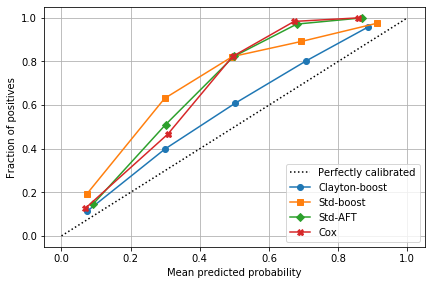

In [4]:
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(3, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:1, :1])

disp = CalibrationDisplay.from_predictions(y_l,1-prob_pred, ax = ax_calibration_curve, name='Clayton-boost', marker='o')
disp = CalibrationDisplay.from_predictions(y_l,1-prob_aft, ax = ax_calibration_curve, name='Std-boost', marker='s')
disp = CalibrationDisplay.from_predictions(y_l,prob_lifelines, ax = ax_calibration_curve, name='Std-AFT', marker='D')
disp = CalibrationDisplay.from_predictions(y_l,prob_cox, ax = ax_calibration_curve, name='Cox', marker='X')

ax_calibration_curve.grid()
#ax_calibration_curve.set_title("DD")
ax_calibration_curve.plot()